In [1]:
import os
import pandas as pd

dataset_path = os.path.realpath(os.path.join(os.path.dirname(__name__), '..', 'app','static','uploads', 'dataset.csv'))
df_comments = pd.read_csv(dataset_path)
df_comments.tail(n=99)

,comment,label
0,Sumpah ya Avoskin cica mugwort gue pKe malah j...,negatif
1,Selama ini base makeupnya wardah kayak susah b...,negatif
2,Ka Lip itu lipstik yg dipegang waktu akhir2 pa...,negatif
3,salah satu produk lokal ter luv yg aku punya! ...,positif
4,Waw Kaka kulit nya bagus bgt pake sabun mandi ...,positif
5,Asalamualaikumyasalam emuah.cantiknya tasya fa...,positif


In [2]:
# Melihat jumlah data
df_comments['label'].value_counts()

label
negatif    3
positif    3
Name: count, dtype: int64

#### Preprocessing

In [3]:
import re
import string
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords

stemmer = StemmerFactory().create_stemmer()
stopword_factory = StopWordRemoverFactory()
combined_stopwords = set(stopword_factory.get_stop_words()).union(set(stopwords.words('english')))

def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def preprocess_text(text):
    text = clean_text(text).lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in combined_stopwords]
    stemmed = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed)


df_comments['preprocess'] = df_comments['comment'].apply(preprocess_text)
df_comments

,comment,label,preprocess
0,Sumpah ya Avoskin cica mugwort gue pKe malah j...,negatif,sumpah avoskin cica mugwort gue pke malah jera...
1,Selama ini base makeupnya wardah kayak susah b...,negatif,lama base makeupnya wardah kayak susah banget ...
2,Ka Lip itu lipstik yg dipegang waktu akhir2 pa...,negatif,ka lip lipstik yg pegang waktu akhir pas ngomo...
3,salah satu produk lokal ter luv yg aku punya! ...,positif,salah satu produk lokal ter luv yg aku punya b...
4,Waw Kaka kulit nya bagus bgt pake sabun mandi ...,positif,waw kaka kulit nya bagus bgt pake sabun mandi ...
5,Asalamualaikumyasalam emuah.cantiknya tasya fa...,positif,asalamualaikumyasalam emuahcantiknya tasya far...


#### Visual Polarisasi Kata

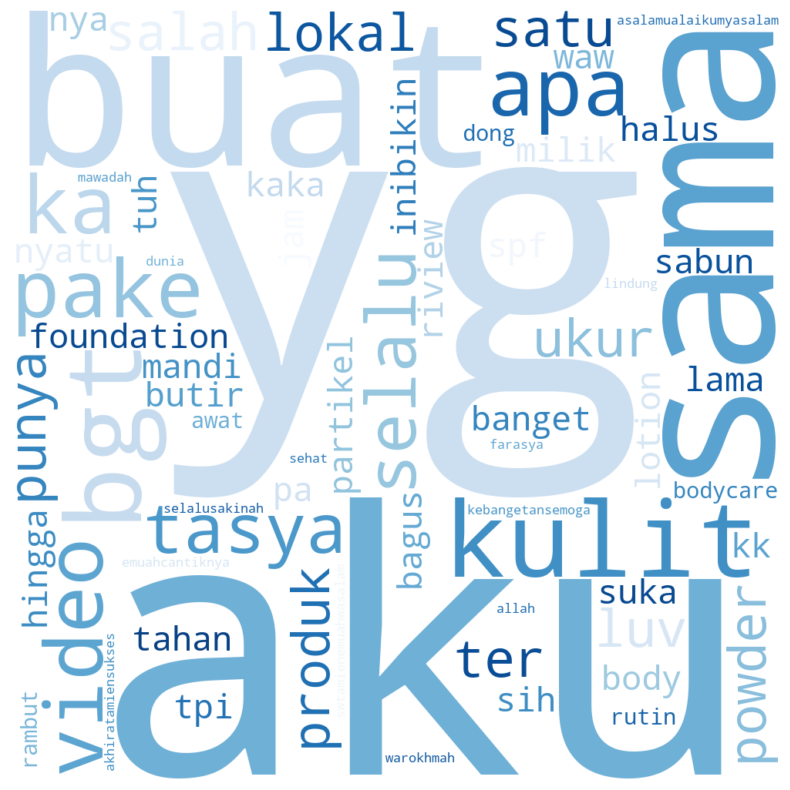

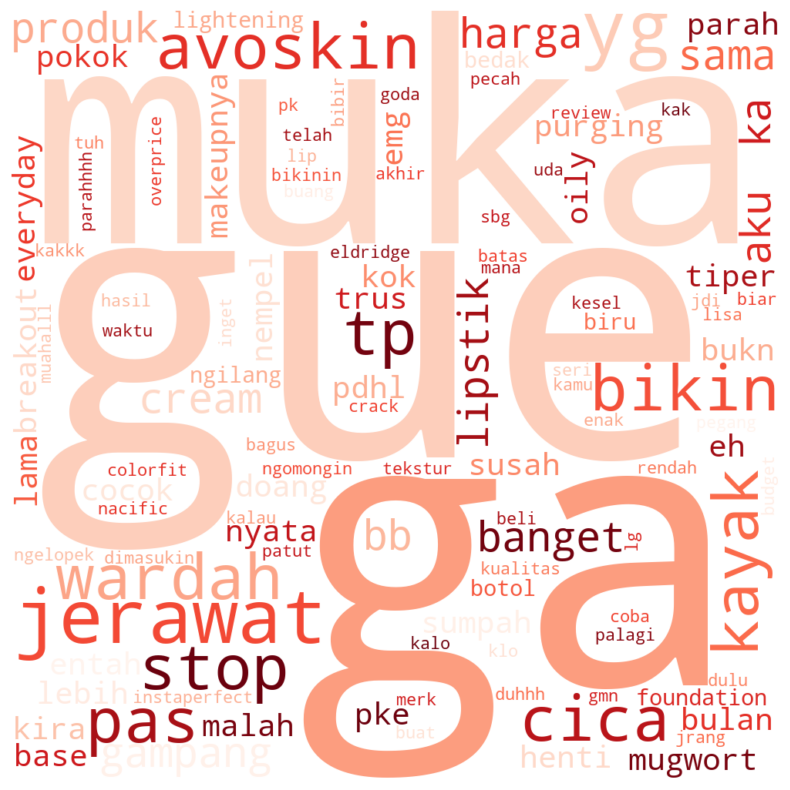

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# polarisasi positif
dataset_negatif = df_comments[df_comments['label'] == 'positif']
dataset_negatif_text = ' '.join(word for word in dataset_negatif['preprocess'])
wc = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(dataset_negatif_text)
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

# polarisasi negatif
dataset_negatif = df_comments[df_comments['label'] == 'negatif']
dataset_negatif_text = ' '.join(word for word in dataset_negatif['preprocess'])
wc = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(dataset_negatif_text)
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

#### Bagi dataset menjadi 80% data training dan 20% data testing

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_comments['preprocess'], df_comments['label'], test_size=0.2, stratify=df_comments['label'], random_state=0)

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# Assume df_comments['preprocess'] contains preprocessed text
vectorizer = TfidfVectorizer()
vectorizer.fit(df_comments['preprocess'])

terms = vectorizer.get_feature_names_out()
idf_values = vectorizer.idf_

# Create DataFrame for IDF values
idf_df = pd.DataFrame(idf_values, index=terms, columns=["IDF"])

# Function to compute raw TF (counts of terms in document)
def compute_raw_tf(doc):
    words = doc.split()
    count = Counter(words)
    return count

# Compute raw TF for each document (term count)
raw_tf_dicts = [compute_raw_tf(doc) for doc in df_comments['preprocess']]
raw_tf_df = pd.DataFrame(raw_tf_dicts, index=[f'D{i+1}' for i in range(len(df_comments['preprocess']))]).T

# Compute normalized TF (TFN)
def compute_tf(doc):
    words = doc.split()
    count = Counter(words)
    total_terms = len(words)
    tf = {term: count[term] / total_terms for term in count}
    return tf

# Compute normalized TF for each document
tf_dicts = [compute_tf(doc) for doc in df_comments['preprocess']]
tf_df = pd.DataFrame(tf_dicts, index=[f'D{i+1}' for i in range(len(df_comments['preprocess']))]).T

# Fill NaN values with 0
raw_tf_df = raw_tf_df.fillna(0)
tf_df = tf_df.fillna(0)
idf_df = idf_df.fillna(0)

# Sum all normalized TF values across all documents (TFNormAll)
tf_norm_all = tf_df.sum(axis=1)

# Compute Document Frequency (DF) - number of documents where the term appears
df_values = (raw_tf_df > 0).sum(axis=1)

# Create final DataFrame
final_df = pd.DataFrame(index=terms)
final_df['Terms'] = terms

# Add raw TF for each document (Raw Terms per document)
final_df = final_df.join(raw_tf_df.add_prefix('TF'))  # Add raw term counts for each document

# Add normalized TF for each document
final_df = final_df.join(tf_df.add_prefix('TFN'))  # Add normalized TF for each document

# Add sum of normalized TFs across all documents
final_df['TFNAll'] = tf_norm_all

# Add Document Frequency (DF) column
final_df['DF'] = df_values

# Add IDF column
final_df['IDF'] = idf_df['IDF']

# Manual TF-IDF calculation: TFN * IDF for each document
for doc in [f'D{i+1}' for i in range(len(df_comments['preprocess']))]:
    final_df[f'TFIDF_{doc}'] = final_df[f'TFN{doc}'] * final_df['IDF']

# Round all numeric columns to 3 decimal places
final_df = final_df.round(3)

# Export the final DataFrame to CSV
final_df.to_csv('combined_tfidf_output_manual.csv', index=False)



Exported 'combined_tfidf_output_manual.csv' with manually calculated TF-IDF values rounded to 3 decimal places.


In [7]:
# run once
# Vektor Hasil tranformasi term data testing dengan data training
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# print(X_train.toarray())
# print(X_test.toarray())

#### Prediksi Kelas Dataset

In [9]:
# Tampilkan hasil prediksi data test
from sklearn.svm import SVC

model = SVC(random_state=0, kernel='linear')

model.fit(X_train, y_train)
predict = model.predict(X_test)
print(predict)


['negatif' 'negatif']


#### Hitung Akurasi

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# f1-score
print('F1-Score : ', f1_score(y_test, predict, pos_label='positif'))
# Accuracy
print('Accuracy : ', accuracy_score(y_test, predict))
# precision
print('Precision : ', precision_score(y_test, predict, pos_label='positif'))
# recall
print('Recall : ', recall_score(y_test, predict, pos_label='positif'))


# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
tn, fp, fn, tp
